<a href="https://colab.research.google.com/github/nhitrantq/test/blob/main/Data_augmentation_for_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation for intent prediction



In intent detection, user needs to define some examples (phrases) of intent that he wants to be detected.

The NLP model needs as many as possible examples to be able to predict correct intents. 

Nevertheless, it happens that user provides small intents with very few examples or even just one message; because of the lack of ideas on intent's phrases, the time constraints, etc.. 

In such cases, it is important to be able to automatically collect more data for small intents before making classification.

This notebook studies how to improve the intent detection using data augmentation. 

Three methodes to enrich the training data will be explored, including:
1. Oversampling intent
2. Back translation
3. Paraphrase generation

# Set up

In [ ]:
from google.colab import drive
drive.mount('/colab-data-drive')

Mounted at /colab-data-drive


In [ ]:
!pip install deep_translator
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.0 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to /tmp/pip-req-build-eu60lbz2
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git /tmp/pip-req-build-eu60lbz2
  Resolved https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to commit 720a87a1ee557d8ed8d9a021adbdd1dd5616c5f9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from collections import Counter

import random

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from deep_translator import GoogleTranslator, MyMemoryTranslator

from parrot import Parrot

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import FrenchStemmer

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preparation

## Load data

In the following experiments, we use a supervised dataset including users' messages and theirs intent (label). 


In [ ]:
# load data
data_fn=r"/colab-data-drive/MyDrive/Colab Notebooks/data/DEMO_generated_data - Copie.xlsx"

def load_training_text(testing_data_fn):
    messages = []
    df = pandas.read_excel(testing_data_fn, header = None)
    return df

df = load_training_text(data_fn)

## Analyze data

In [ ]:
# display data examples
df.head(20)

,0,1,2,3
0,fr,5f86f3bb4edf1d3f90d34c70,Peux tu m'envoyer mon identifiant client ?,get_id_client
1,fr,5f86f3bb4edf1d3f90d34c70,J'ai perdu mon identifiant client,get_id_client
2,fr,5f86f3bb4edf1d3f90d34c70,J'ai oublié mon identifiant client,get_id_client
3,fr,5f86f3bb4edf1d3f90d34c70,Je ne me souviens plus de mon identifiant client,get_id_client
4,fr,5f86f3bb4edf1d3f90d34c70,Peux-tu me donner mon identifiant client ?,get_id_client
5,fr,5f86f3bb4edf1d3f90d34c70,Puis-je avoir mon identifiant client ?,get_id_client
6,fr,5f86f3bb4edf1d3f90d34c70,Donne moi mon identifiant client,get_id_client
7,fr,5f86f3bb4edf1d3f90d34c70,J'aimerais avoir mon identifiant client,get_id_client
8,fr,5f86f3bb4edf1d3f90d34c70,Je veux avoir mon identifiant client,get_id_client
9,fr,5f86f3bb4edf1d3f90d34c70,Je souhaiterais avoir mon identifiant client,get_id_client


To build our intent classifier, we are only interessed in the last two columns which are the message and the intent name. 

In [ ]:
# get data infos
all_messages = []
all_intents = []

for i, row in df.iterrows():
  lang, intent_id, message, intent_name, *_ = row

  all_messages.append(message)
  all_intents.append(intent_name)

print(f"The loaded data has:")
print(f"\t{len(all_messages)} messages")
print(f"\t{len(set(all_intents))} intents")
print(f"\taverage: {int(len(all_messages)/len(set(all_intents)))} messages per intent")

The loaded data has:
	287 messages
	24 intents
	average: 11 messages per intent


We visualize the distribution of data over the intents.

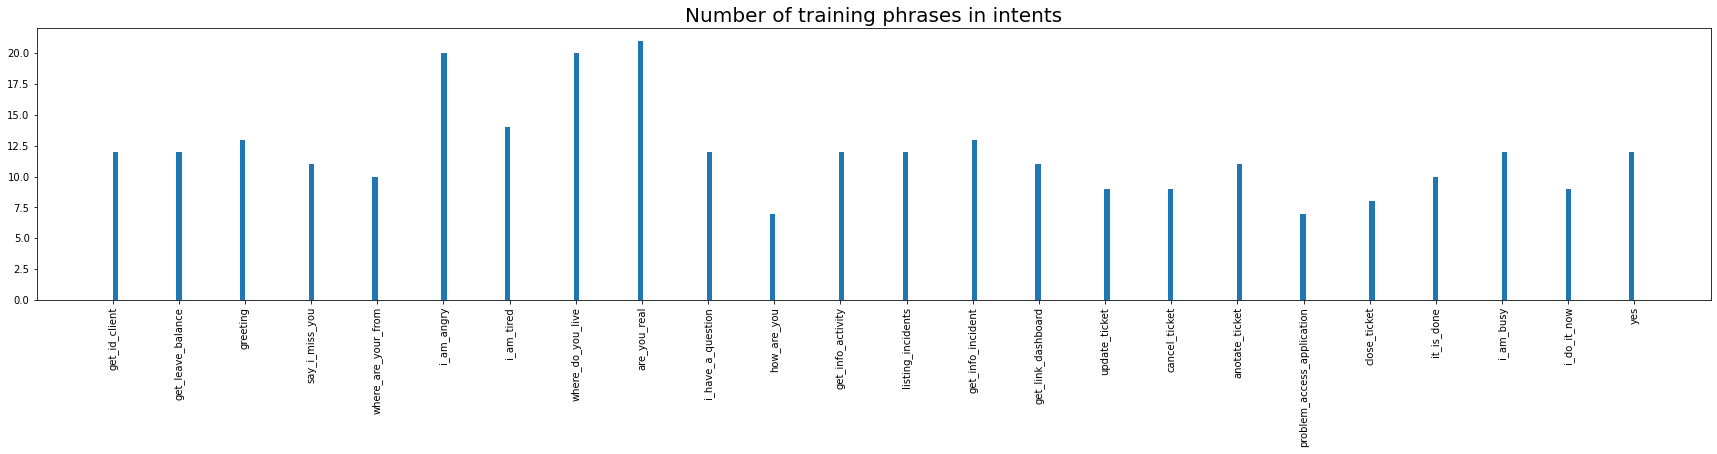

In [ ]:
# get number of training phrases in intents
plt.figure(figsize=(30,5))
plt.hist(all_intents, bins=len(all_intents))
plt.xticks(rotation='vertical')
plt.title('Number of training phrases in intents',{'fontsize': 20})
plt.show()

The data is quite balanced. 

## Split data

We now split the data into training and testing sets, respectively used for building and predicting intents.

For the sake of this study, we need to have some minor intents in our data. 
To do this, we randomly select 5 intents and make them become minor intents. 
For these 5 intents, half of phrases will be used for training and the others for testing. For the other intents, we will use 70% phrases for training and 30% for testing. 


In [ ]:
# uncomment this code if you want to try with other minor intents
# random.seed(42)
# minor_intents = random.sample(list(set(all_intents)), 5)
# print("5 selected minor intents name :")
# for mi in minor_intents:
#   print(f"\t{mi}")

minor_intents = [
    'greeting',
    'how_are_you',
    'get_id_client',
    'cancel_ticket',
    'i_do_it_now'
]

In [ ]:
# get info of the minor intents and other intents
minor_intents_messages = []
minor_intents_labels = []

other_messages = []
other_labels = []

for i in range(len(all_intents)):
  if all_intents[i] in minor_intents:
    minor_intents_messages.append(all_messages[i])
    minor_intents_labels.append(all_intents[i])
  else:
    other_messages.append(all_messages[i])
    other_labels.append(all_intents[i])

print(f"Nb messages in total: {len(all_messages)}")
print(f"Nb messages in {len(minor_intents)} minor intents:  {len(minor_intents_messages)}")
print(f"Nb messages in {len(set(all_intents)) - len(minor_intents)} other intents:  {len(other_messages)}")

Nb messages in total: 287
Nb messages in 5 minor intents:  50
Nb messages in 19 other intents:  237


In [ ]:
# split data of minor intents
minor_intents_train_messages, minor_intents_test_messages, minor_intents_train_labels, minor_intents_test_labels = train_test_split(minor_intents_messages, minor_intents_labels, test_size=0.7, stratify=minor_intents_labels, random_state=42)

# split data of other intents
other_train_messages, other_test_messages, other_train_labels, other_test_labels = train_test_split(other_messages, other_labels, test_size=0.2, stratify=other_labels, random_state=42)


In [ ]:
# collect training data of all intents
train_messages = minor_intents_train_messages + other_train_messages
train_labels = minor_intents_train_labels + other_train_labels

# collect testing data of all intents
test_messages = minor_intents_test_messages + other_test_messages
test_labels = minor_intents_test_labels + other_test_labels

In [ ]:
print(f'Training - Nb of messages: {len(train_messages)}')
print(f'Training - Nb of intents: {len(set(train_labels))}')

print(f'Testing - Nb of messages: {len(test_messages)}')
print(f'Testing - Nb of intents: {len(set(test_labels))}')


Training - Nb of messages: 204
Training - Nb of intents: 24
Testing - Nb of messages: 83
Testing - Nb of intents: 24


In [ ]:
# distribution of data over intents
train_counter = Counter(train_labels)
test_counter = Counter(test_labels)

for intent_ in train_counter:
  print(f"Intent '{intent_}' : {train_counter[intent_]} trainings, {test_counter[intent_]} testings")

Intent 'cancel_ticket' : 3 trainings, 6 testings
Intent 'greeting' : 4 trainings, 9 testings
Intent 'i_do_it_now' : 3 trainings, 6 testings
Intent 'how_are_you' : 2 trainings, 5 testings
Intent 'get_id_client' : 3 trainings, 9 testings
Intent 'where_do_you_live' : 16 trainings, 4 testings
Intent 'problem_access_application' : 6 trainings, 1 testings
Intent 'listing_incidents' : 9 trainings, 3 testings
Intent 'i_am_busy' : 9 trainings, 3 testings
Intent 'i_am_angry' : 16 trainings, 4 testings
Intent 'get_info_activity' : 9 trainings, 3 testings
Intent 'update_ticket' : 7 trainings, 2 testings
Intent 'get_info_incident' : 10 trainings, 3 testings
Intent 'i_am_tired' : 11 trainings, 3 testings
Intent 'anotate_ticket' : 9 trainings, 2 testings
Intent 'get_link_dashboard' : 9 trainings, 2 testings
Intent 'where_are_your_from' : 8 trainings, 2 testings
Intent 'are_you_real' : 17 trainings, 4 testings
Intent 'it_is_done' : 8 trainings, 2 testings
Intent 'close_ticket' : 6 trainings, 2 testing

# Baseline

The baseline consists in building the intent predictor using the original data. No data augmentation technique will be used in this experiment. 

The pipeline is the following:


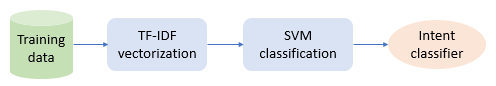

We start with some text preprocessing, such as tokenization and stemming before extracting the TF-IDF vectors of the training data. 

In [ ]:
def tokenize_text(text):
    alphanumeric_characters = "a-zA-ZàâäôéèëêïîçùûüÿæœÀÂÄÔÉÈËÊÏÎŸÇÙÛÜÆŒ0-9"
    delimiter_pattern = '[^' + alphanumeric_characters + ']'

    words = text.split()

    tokens = []
    for word in words:
        tokens = tokens + re.split(delimiter_pattern, word)

    tokens = filter(lambda x: len(x) > 1, tokens)
    tokens = [w.lower() for w in tokens]

    return tokens

In [ ]:
class Stemming(object):
    def __init__(self):
        self.fr_stm = FrenchStemmer(ignore_stopwords=True)

    def __call__(self, text):
        return [self.fr_stm.stem(t) for t in tokenize_text(text)]

In [ ]:
def train_tfidf_vectorizer(messages):
    vectorizer = TfidfVectorizer(lowercase=True, 
                                  stop_words=list(set(stopwords.words('french'))), 
                                  use_idf=True,
                                  tokenizer=Stemming(), 
                                  ngram_range=(1, 1))
    vectorizer.fit(messages)

    print(f"{len(vectorizer.get_feature_names_out())} words in vocabulary used for extracting TF-IDF")
    print(vectorizer.get_feature_names_out())

    return vectorizer

In [ ]:
def transform_tfidf(vectorizer, messages):
    return vectorizer.transform(messages)

In [ ]:
# build TFIDF vectorizer
vectorizer = train_tfidf_vectorizer(train_messages)

151 words in vocabulary used for extracting TF-IDF
['absenc' 'acced' 'accompl' 'activ' 'affirm' 'agent' 'aim' 'air' 'ajout'
 'allez' 'annul' 'appli' 'appliqu' 'arriv' 'aujourd' 'avoir' 'beaucoup'
 'besoin' 'bien' 'bonjour' 'bot' 'bug' 'chang' 'chat' 'chatbot' 'client'
 'coler' 'combien' 'comment' 'commentair' 'complet' 'cong' 'connect'
 'conversationnel' 'coucou' 'crev' 'dashboard' 'dat' 'dis' 'don' 'déjà'
 'détail' 'ennui' 'entrepris' 'envoi' 'fach' 'fair' 'fais' 'fait' 'fatigu'
 'faut' 'ferm' 'fourn' 'franc' 'furieux' 'fâch' 'habit' 'hey' 'horair'
 'hui' 'humain' 'identifi' 'incident' 'indident' 'inform' 'infos' 'joint'
 'jour' 'journ' 'lien' 'list' 'mainten' 'manqu' 'march' 'merc' 'met'
 'mettr' 'modif' 'modifi' 'mou' 'nombr' 'non' 'obten' 'occup' 'origin'
 'ouai' 'ouaiii' 'ouaip' 'ouais' 'ouii' 'ouvert' 'ouvr' 'où' 'pay'
 'person' 'peux' 'piec' 'pj' 'pris' 'problem' 'prévu' 'puis' 'quand'
 'quel' 'question' 'quoi' 're' 'rempl' 'rend' 'resalut' 'rest' 'robot'
 'récuper' 'réel' 'répo

In [ ]:
# extract TF-IDF vectors of training messages
train_tfidf = transform_tfidf(vectorizer, train_messages)

# extract TF-IDF vectors of test messages
test_tfidf = transform_tfidf(vectorizer, test_messages)

In [ ]:
print(f"Shape of tfidf of training data :  {train_tfidf.shape}")
print(f"\t{train_tfidf.shape[0]} vectors TF-IDF")
print(f"\t{train_tfidf.shape[1]} dimensions in each vector")

print(f"Shape of tfidf of testing data :  {test_tfidf.shape}")
print(f"\t{test_tfidf.shape[0]} vectors TF-IDF")
print(f"\t{test_tfidf.shape[1]} dimensions in each vector")

Shape of tfidf of training data :  (204, 151)
	204 vectors TF-IDF
	151 dimensions in each vector
Shape of tfidf of testing data :  (83, 151)
	83 vectors TF-IDF
	151 dimensions in each vector


In [ ]:
def build_classifier(features, labels):

    classifier=SVC(random_state=42, probability=True, class_weight='balanced')

    c_values = [1.0,10.0,100.0,500.0,1000.0]
    g_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    d_values = [2,3,4]    
    parameters=[
        {'C': c_values,'kernel': ['linear']},
        {'C': c_values,'kernel': ['rbf'],'gamma': g_values} ,
        {'C': c_values,'kernel': ['poly'],'gamma': g_values,'degree': d_values}
    ]

    # Grid search
    grid_search = GridSearchCV(classifier, parameters, cv=5)
    grid_search.fit(features, labels)

    print('Best parameters : ', grid_search.best_params_)
    print('Best score : ', grid_search.best_score_)

    classifier=SVC(**grid_search.best_params_, random_state=42, probability=True, class_weight='balanced')

    classifier.fit(features, labels)

    return classifier

In [ ]:
baseline_classifier = build_classifier(train_tfidf, train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters :  {'C': 1.0, 'kernel': 'linear'}
Best score :  0.8675609756097561


In [ ]:
def evaluate(labels, predicitions):

    acc=accuracy_score(labels, predicitions)
    print('Accuracy : ', round(acc,2))

    f1_sc = f1_score(labels, predicitions, average='macro')
    print('F1 Score (macro) : ', round(f1_sc, 2))

    nb_incorrect_detection = 0
    incorrect_preds = [i for i in range(len(predicitions)) if predicitions[i] != labels[i]]

    incorrect_preds_rate = round(len(incorrect_preds) / len(labels), 2)

    print(f'Incorrect detection rate : {len(incorrect_preds)}/{len(labels)} ({incorrect_preds_rate})')

    # print("\nIncorrect predictions:")
    # for i_pred in incorrect_preds: 
    #   print(f'{test_messages[i_pred]}')
    #   if labels[i_pred] in minor_intents:
    #     print(f'\tlabel : {labels[i_pred]} (minor intent)')
    #   else:
    #     print(f'\tlabel : {labels[i_pred]}')
    #   print(f'\tpredicted : {predicitions[i_pred]}')

    return acc, f1_sc, incorrect_preds_rate


In [ ]:
# predictions on test messages
baseline_predictions = baseline_classifier.predict(test_tfidf)

# display metrics
baseline_acc, baseline_f1, baseline_incorrect_pred_rate = evaluate(test_labels, baseline_predictions)

Accuracy :  0.88
F1 Score (macro) :  0.89
Incorrect detection rate : 10/83 (0.12)


# Oversampling

This method consists in duplicating phrases in all intents so that every intent has the same quantity of phrases of the largest intent. 

The pipeline is the same as in baseline. However, a larger volumn of messages are used for training the model. 

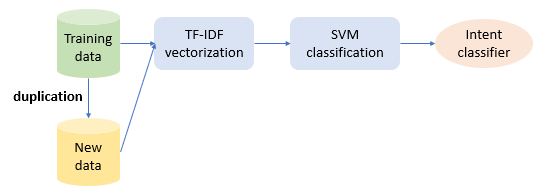

In [ ]:
max_size_intent = max(train_counter.values())
print(f'Number of training messages in the biggest intent : {max_size_intent}')

Number of training messages in the biggest intent : 17


In [ ]:
# duplicate phrases in order to have max_size_intent messages per intent
oversampled_train_labels = []
oversampled_train_messages = []

for intent_, count_ in train_counter.items():

  intent_phrases = []
  intent_features = []

  for i in range(len(train_labels)):
    if train_labels[i] == intent_:
      intent_phrases.append(train_messages[i])

  if count_ < max_size_intent:
    nb_dupplicate = max_size_intent // count_
    remainder = max_size_intent % count_
    
    new_intent_phrases = intent_phrases * nb_dupplicate + intent_phrases[:remainder]

    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_messages = oversampled_train_messages + new_intent_phrases

  else:
    oversampled_train_labels = oversampled_train_labels + [intent_] * max_size_intent
    oversampled_train_messages = oversampled_train_messages + intent_phrases

In [ ]:
print(f"Before oversampling - Nb of phrases in training data: {len(train_messages)}")
print(f"After oversampling - Nb of phrases in training data: {len(oversampled_train_messages)}")
print(f"Nb of duplicated phrases in training data: {len(oversampled_train_messages) - len(train_messages)}")

Before oversampling - Nb of phrases in training data: 204
After oversampling - Nb of phrases in training data: 408
Nb of duplicated phrases in training data: 204


In [ ]:
# extract TF-IDF of training data
oversampling_train_tfidf = transform_tfidf(vectorizer, oversampled_train_messages)

In [ ]:
# classfication
oversampling_classifier = build_classifier(oversampling_train_tfidf, oversampled_train_labels)

Best parameters :  {'C': 10.0, 'kernel': 'linear'}
Best score :  0.9730502860584161


In [ ]:
# prediction
oversampling_predictions = oversampling_classifier.predict(test_tfidf)

# evaluate
oversampling_acc,oversampling_f1, oversampling_incorrect_pred_rate = evaluate(test_labels, oversampling_predictions)

Accuracy :  0.88
F1 Score (macro) :  0.89
Incorrect detection rate : 10/83 (0.12)


# Back translation

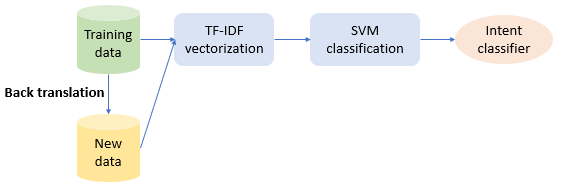

In this experiment, we explore the back translation technique to generate new messages. 

It consists of three steps:
1.   **Temporary translation**: translate each of the original training labeled data into a different language. In our case, it will be from French to English.
2.   **Back translation**: translate back each of those translated data into the original language, meaning a translation from English to French.
3.   **Duplicate removal**: at the end of the process, we will have for each original text data, its corresponding back-translation. We keep only one occurrence of each duplicate.

An example of the back translation for an original english text:

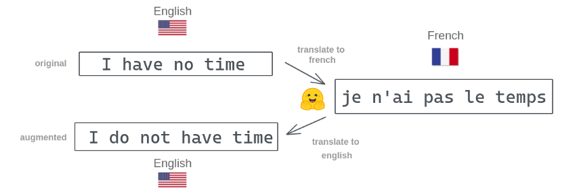

We use GoogleTranslator for the translation. 
Note that for a message, GoogleTranslator returns only one translation. 

In [ ]:
# initialize two translators
google_translator_fr_en = GoogleTranslator(source='fr', target='en')
google_translator_en_fr = GoogleTranslator(source='en', target='fr')

In [ ]:
# example back translation
original_text = 'comment vas-tu ?'
translation_en = google_translator_fr_en.translate(original_text)
translation_fr = google_translator_en_fr.translate(translation_en)

print(f'Original text : {original_text}')
print(f'Temporary translation : {translation_en}')
print(f'Back translation : {translation_fr}')

Original text : comment vas-tu ?
Temporary translation : How are you ?
Back translation : Comment allez-vous ?


In [ ]:
def _translate_original_message(phrase):
    gg_translation_en = google_translator_fr_en.translate(phrase)
    gg_translation_fr = google_translator_en_fr.translate(gg_translation_en)
    return list(set([phrase.lower(), gg_translation_fr.lower()]))

In [ ]:
def back_translation(train_messages, train_labels):

  backtranslation_train_messages = []
  backtranslation_train_labels = []

  counter = 0

  for phrase_, label_ in zip(train_messages, train_labels):

    counter+=1
    if counter % 20 == 0:
      print(f"Translation in progress : {round(counter/len(train_messages), 2) * 100} %")

    translations = _translate_original_message(phrase_)

    print(f'{phrase_}')
    print(f'\t{translations}')
    
    for translation_ in translations:
      backtranslation_train_messages.append(translation_)
      backtranslation_train_labels.append(label_)

  return backtranslation_train_messages, backtranslation_train_labels
      

In [ ]:
backtranslation_train_messages, backtranslation_train_labels = back_translation(train_messages, train_labels)

J'ai besoin d'annuler mon ticket
	["j'ai besoin d'annuler mon ticket", 'je dois annuler mon billet']
hey
	['hey', 'hé']
je vais le faire maintenant
	['je vais le faire maintenant']
Je souhaitereais annuler un ticket incident
	['je souhaitereais annuler un ticket incident', "je souhaite annuler un ticket d'incident"]
Vous allez bien ?
	['vous allez bien ?', 'tu vas bien ?']
Comment va
	['comment va', 'comment allez-vous']
Je souhaiterais avoir mon identifiant client
	['je souhaite avoir mon identifiant client', 'je souhaiterais avoir mon identifiant client']
coucou
	['coucou', 'bonjour']
je le remplis maintenant
	['je le remplis maintenant']
Peux tu m'envoyer mon identifiant client ?
	["peux tu m'envoyer mon identifiant client ?", "pouvez-vous m'envoyer mon identifiant client ?"]
Peux-tu annuler mon ticket ?
	['pouvez-vous annuler mon billet ?', 'peux-tu annuler mon ticket ?']
je le fais toute de suite
	['je le fais tout de suite', 'je le fais toute de suite']
re bonjour
	['re bonjour',

In [ ]:
print(f"Nb of phrases in training data (initial): {len(train_messages)}")
print(f"Nb of phrases in training data with translations: {len(backtranslation_train_messages)}")
print(f"Nb of new phrases (translations) added in training data: {len(backtranslation_train_messages) - len(train_messages)}")

Nb of phrases in training data (initial): 204
Nb of phrases in training data with translations: 363
Nb of new phrases (translations) added in training data: 159


In [ ]:
vectorizer = train_tfidf_vectorizer(backtranslation_train_messages)

backtranslation_train_tfidf = transform_tfidf(vectorizer, backtranslation_train_messages)
backtranslation_test_tfidf = transform_tfidf(vectorizer, test_messages)

179 words in vocabulary used for extracting TF-IDF
['absenc' 'acced' 'accompl' 'activ' 'affirm' 'agent' 'aim' 'air' 'ajout'
 'allez' 'annul' 'appli' 'appliqu' 'arriv' 'aujourd' 'avoir' 'beaucoup'
 'besoin' 'bien' 'billet' 'bonjour' 'bord' 'bot' 'bug' 'cel' 'chang'
 'chat' 'chatbot' 'client' 'clôtur' 'coler' 'combien' 'comment'
 'commentair' 'complet' 'cong' 'connaîtr' 'connect' 'conversationnel'
 'coucou' 'crev' 'crédibl' 'dashboard' 'dat' 'dis' 'dit' 'dois' 'don'
 'déjà' 'détail' 'ennui' 'entrepris' 'envoi' 'ete' 'fach' 'fair' 'fais'
 'fait' 'fatigu' 'faut' 'ferm' 'fin' 'fonction' 'fourn' 'franc' 'furieux'
 'fâch' 'habit' 'hey' 'horair' 'hui' 'humain' 'hyp' 'hé' 'identifi'
 'incident' 'indemn' 'indident' 'indépend' 'inform' 'infos' 'joint' 'jour'
 'journ' 'lien' 'list' 'mainten' 'manqu' 'march' 'merc' 'met' 'mettr'
 'modif' 'modifi' 'mou' 'natal' 'nombr' 'non' 'obten' 'occup' 'origin'
 'ouai' 'ouaiii' 'ouaip' 'ouais' 'oui' 'ouii' 'ouvert' 'ouvr' 'où' 'pay'
 'person' 'peux' 'piec' 'pj'

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
backtranslation_classifier = build_classifier(backtranslation_train_tfidf, backtranslation_train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters :  {'C': 1.0, 'kernel': 'linear'}
Best score :  0.9146879756468798


In [ ]:
backtranslation_predictions=backtranslation_classifier.predict(backtranslation_test_tfidf)

backtranslation_acc, backtranslation_f1, backtranslation_incorrect_pred_rate = evaluate(test_labels, backtranslation_predictions)

Accuracy :  0.96
F1 Score (macro) :  0.97
Incorrect detection rate : 3/83 (0.04)


Notes:


*   The translator may return different results over executions. This is normal to get slightly different performance of prediction.
*   You can observe sometime a surprising translation: your back translation can be the same as the original text. This will not help you a lot to improve your data. Try to use at least 2 translators : one for temporary translation and another for back translation. This can help you having a back translation different from the original message. 



# Paraphrasing

To have more variations of a message, we want to generate more examples that preserve the initial meaning of message with different choices of word and grammar. Paraphrase is one of the techniques allowing doing this. 

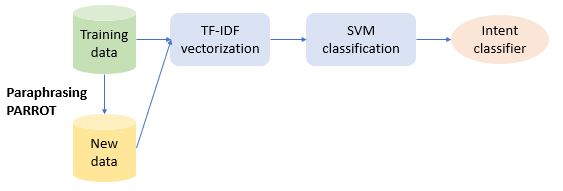

To generate paraphrases, we use Parrot
https://github.com/PrithivirajDamodaran/Parrot_Paraphraser

Note that this framework works only for english text. For other language, we can translate our text in english, apply Parrot generator and then retranslate generated phrases in initial language. For sure, the quality of translation has an important impact on the final data. 




In [ ]:
import torch
import warnings
warnings.filterwarnings("ignore")

''' 
uncomment to get reproducable paraphrase generations
def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)
'''

#Init models (make sure you init ONLY once if you integrate this to your code)
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")


Downloading:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/913 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
def generate_paraphrases(train_messages, train_labels):

  paraphrases_train_messages = []
  paraphrases_train_labels = []

  counter = 0

  for phrase_, label_ in zip(train_messages, train_labels):

    # add original phrase
    paraphrases_train_messages.append(phrase_)
    paraphrases_train_labels.append(label_)

    counter+=1
    if counter % 20 == 0:
      print(f"Paraphrasing in progress : {round(counter/len(train_messages), 2) * 100} %")

    # translate phrase in en before generating paraphrases
    google_translator = GoogleTranslator(source='fr', target='en')
    phrase_en = google_translator.translate(phrase_)

    # paraphrases
    para_phrases_en = parrot.augment(input_phrase=phrase_en, use_gpu=False)

    if not para_phrases_en:
      continue

    google_translator = GoogleTranslator(source='en', target='fr')

    # translate paraphrases from en to fr
    para_phrases_fr = [google_translator.translate(pp_en).lower() for pp_en, _ in para_phrases_en]

    for pp_fr in list(set(para_phrases_fr)):
      paraphrases_train_messages.append(pp_fr)
      paraphrases_train_labels.append(label_)

  return paraphrases_train_messages, paraphrases_train_labels

It takes about 20 minutes to generate and translate all paraphrases. You can uncomment the function and directly download the result from file. 

In [ ]:
# uncomment the following code if you want to generate paraphrases; it takes about 20 minutes
# paraphrases_train_messages, paraphrases_train_labels = generate_paraphrases(train_messages, train_labels)


In [ ]:
# load generated paraphrases from file
# comment this code if you already called the generate_paraphrases() function
paraphrases_train_messages = []
paraphrases_train_labels = []

with open(r"/colab-data-drive/MyDrive/Colab Notebooks/data/paraphrases_train_messages_labels.txt", 'r') as f:
  for l in f.readlines():
    m, i = l.strip().split('###')
    paraphrases_train_messages.append()
    paraphrases_train_labels.append()

In [ ]:
# display paraphrases
def display_paraphrases_intent(intent_name):
  print(f"Intent '{intent_name}'")
  org_phrases = "\n\t\t".join([m for m, i in zip(train_messages, train_labels) if i == intent_name])
  test_phrases = "\n\t\t".join([m for m, i in zip(test_messages, test_labels) if i == intent_name])
  all_phrases = "\n\t\t".join([m for m, i in zip(paraphrases_train_messages, paraphrases_train_labels) if i == intent_name])
  print(f'\tOriginal phrases : \n\t\t{org_phrases}')
  print(f'\tOriginal phrases + paraphrases : \n\t\t{all_phrases}')
  print(f'\tTesting phrases : \n\t\t{test_phrases}')

display_paraphrases_intent('how_are_you')
display_paraphrases_intent('greeting')

Intent 'how_are_you'
	Original phrases : 
		Vous allez bien ?
		Comment va
	Original phrases + paraphrases : 
		Vous allez bien ?
		comment est votre état de santé?
		Comment va
		comment allez vous?
		comment vas-tu?
	Testing phrases : 
		Comment allez-vous
		Tu vas bien?
		bien ou bien
		ça va ?
		Comment vas-tu
Intent 'greeting'
	Original phrases : 
		hey
		coucou
		re bonjour
		resalut
	Original phrases + paraphrases : 
		hey
		hé
		coucou
		bonjour
		re bonjour
		rebonjour
		resalut
		salut
	Testing phrases : 
		salut
		allo
		bonjour à toi
		bonjour
		salutations
		salut à tous
		re salut
		rebonjour
		hé


In [ ]:
print(f"Nb of phrases in training data (initial): {len(train_messages)}")
print(f"Nb of phrases in training data with paraphrases: {len(paraphrases_train_messages)}")
print(f"Nb of new phrases (paraphrases) added in training data: {len(paraphrases_train_messages) - len(train_messages)}")

Nb of phrases in training data (initial): 204
Nb of phrases in training data with paraphrases: 565
Nb of new phrases (paraphrases) added in training data: 361


In [ ]:
# build TF-IDF vectorizer
paraphrase_vectorizer = train_tfidf_vectorizer(paraphrases_train_messages)

# extract TF-IDF vectors
paraphrase_train_tfidf = transform_tfidf(paraphrase_vectorizer, paraphrases_train_messages)
paraphrase_test_tfidf = transform_tfidf(paraphrase_vectorizer, test_messages)

223 words in vocabulary
['absenc' 'acced' 'accompl' 'activ' 'affirm' 'agent' 'aim' 'air' 'ajout'
 'allez' 'annul' 'appli' 'appliqu' 'arriv' 'assez' 'aujourd' 'avoir'
 'beaucoup' 'besoin' 'bien' 'billet' 'bonjour' 'bord' 'bot' 'bourr' 'bug'
 'calendri' 'cas' 'cel' 'cet' 'chang' 'chat' 'chatbot' 'cher' 'chos'
 'client' 'clôtur' 'coler' 'combien' 'comment' 'commentair' 'complet'
 'cong' 'connaitr' 'connaîtr' 'connect' 'contrari' 'conversationnel'
 'coucou' 'crev' 'crédibl' 'dashboard' 'dat' 'dir' 'dis' 'discuss' 'dit'
 'dois' 'don' 'déjà' 'dépass' 'dérang' 'détail' 'encor' 'ennui'
 'entrepris' 'envoi' 'ete' 'fach' 'fair' 'fais' 'fait' 'fatigu' 'faut'
 'ferm' 'fin' 'fou' 'fourn' 'franc' 'frustr' 'furieux' 'fâch' 'habit'
 'heureux' 'hey' 'horair' 'hui' 'humain' 'hé' 'identifi' 'incident'
 'inclur' 'incroi' 'indident' 'indépend' 'inform' 'infos' 'joindr' 'joint'
 'jour' 'journ' 'laiss' 'lien' 'lieu' 'list' 'mainten' 'manqu' 'march'
 'merc' 'met' 'mettr' 'modif' 'modifi' 'montr' 'mou' 'nombr'

In [ ]:
# classification
paraphrase_classifier = build_classifier(paraphrase_train_tfidf, paraphrases_train_labels)

Best parameters :  {'C': 10.0, 'gamma': 0.3, 'kernel': 'rbf'}
Best score :  0.9132743362831859


In [ ]:
# prediction
paraphase_predictions = paraphrase_classifier.predict(paraphrase_test_tfidf)

# evaluate
paraphrase_acc, paraphrase_f1, paraphrase_incorrect_pred_rate = evaluate(test_labels, paraphase_predictions)

Accuracy :  0.93
F1 Score (macro) :  0.91
% incorrect detection : 6/83 (0.07)


allo
	label : greeting (minor intent)
	predicted : i_am_angry
ça va ?
	label : how_are_you (minor intent)
	predicted : i_am_angry
je regarde maintenant
	label : i_do_it_now (minor intent)
	predicted : i_am_busy
je le complète maintenant
	label : i_do_it_now (minor intent)
	predicted : it_is_done
oué
	label : yes
	predicted : i_am_angry
oui
	label : yes
	predicted : i_am_angry


(0.927710843373494, 0.9147447868036104, 0.07)

# Conclusion

Here we compare the intent prediction performance using three augmentation data techniques : oversampling, back translation and paraphrasing.

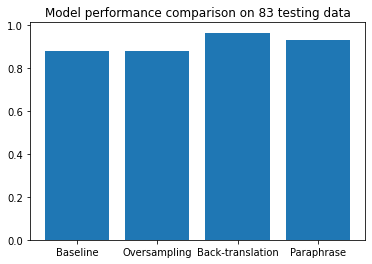

In [ ]:
from numpy import *
import matplotlib.pyplot as plt

plt.bar(['Baseline', 'Oversampling', 'Back-translation', 'Paraphrase'], 
        height=[baseline_acc, oversampling_acc, backtranslation_acc, paraphrase_acc])
plt.title(f'Model performance comparison on {len(test_messages)} testing data')

plt.show()

To our dataset, the oversampling did not improve the performance. The back translation and paraphrasing yield better results than the baseline. 

We observe that the messages in the test set are almost different to the training. By translating or paraphrasing, we succeeded to generate new training phrases that are closer to those in the test set. Training model accounting these new phrases brings improvement on prediction. 

We have some observations during these experiments: 


*   It is important to control and validate the generated data while using back-translation and paraphrasing. More data is good, but more bad data is not. 
As paraphrasing is itself a model learnt from data, it can have some bias and generate phrases with a wrong context with respect to the original meaning. Having these data in our training can harm the intent model. 
*   In this study, we explored the pipeline with the augmentation techniques one by one. It can be interessting to combine the generated data from all methods on which the model will be retrained.
*   On our data, the back translation outperforms the other methods. However, it is not always true on other dataset. You need some tests to figure out the most appropriate augmentation method for your data.


